In [1]:
#pyspark
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import DateType

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#jupyter dataViz opts

plt.rcParams["figure.figsize"] = [20, 8]

# Prepare dataset :

Dataset downloaded from :

https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

https://www.kaggle.com/djonafegnem/chicago-crime-data-analysis

In [2]:
### Columns description from : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

In [3]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''

---

### Clean and prepare Headers :
##### Removing 'Blank space' and replacing it by '_'

In [4]:
#list of headers => list of dictionaries

def entry_dic(line):
    elements = line.split(' - ')
    return {'title': elements[0], 'description': elements[1], 'header': elements[0].lower().replace(' ', '_')}

In [5]:
#Go all over the headers & construct a dictionary 
#Split lines using '\n'

header_dics = list(map(entry_dic, list(filter(lambda l: l != '', content_cols.split('\n')))))

In [6]:
print(header_dics[:2][1]['title'])
#We'll use header, we'll access it using '.'
print(header_dics[:2][1]['header'])

Case Number
case_number


---
### Importing data :


In [7]:
#Loading a data frame from the dataset
df = spark.read.csv('../datasets/*.csv', inferSchema=True, header=True)
df = df.cache()


In [32]:
df.count()

1456714

In [8]:
#Headers of the dataframe
for h in header_dics:
    df = df.withColumnRenamed(h['title'], h['header'])
    
#Our features (columns)
allCols = list(df.columns)
allCols

['_c0',
 'id',
 'case_number',
 'date',
 'block',
 'iucr',
 'primary_type',
 'description',
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'x_coordinate',
 'y_coordinate',
 'year',
 'updated_on',
 'latitude',
 'longitude',
 'location']

---
#### Identify and clean the dirty columns :


In [9]:
for col in allCols:
    print(col, df.filter((df[col] == "") | df[col].isNull()).count())

## Identify the number of Null | NaN | Empty values in every column

('_c0', 0)
('id', 0)
('case_number', 1)
('date', 0)
('block', 0)
('iucr', 0)
('primary_type', 0)
('description', 0)
('location_description', 1658)
('arrest', 0)
('domestic', 0)
('beat', 0)
('district', 1)
('ward', 14)
('community_area', 40)
('fbi_code', 0)
('x_coordinate', 37083)
('y_coordinate', 37083)
('year', 0)
('updated_on', 0)
('latitude', 37083)
('longitude', 37083)
('location', 37083)


#### Getting rid of a rows without value in 'Location description' 
#### Replacing NaN and Null values with 'U' in all other columns (with a lot of gapes)

---
## Visualizing & Understanding the data

In [10]:
# crime types count
crime_type_groups = df.groupBy('primary_type').count()

#crime localisations count
crime_loc_groups = df.groupBy('location_description').count()

In [11]:
#Order the groups we collected

crime_type_counts = crime_type_groups.orderBy('count', ascending=False)
crime_loc_counts = crime_loc_groups.orderBy('count', ascending=False)

### Crime types

These are the top 20 most frequent crime types:

In [12]:
#Crimes types & localizations in numbers :

#crime_type_counts.show(truncate=False)
#crime_loc_counts.show(truncate=False)

#To sum up :: that's how we can see a summary of the 'trending' crimes by types & by locations

df.groupby('primary_type').count().orderBy('count', ascending=False).show()
df.groupby('location_description').count().orderBy('count', ascending=False).show()

+--------------------+------+
|        primary_type| count|
+--------------------+------+
|               THEFT|329460|
|             BATTERY|263700|
|     CRIMINAL DAMAGE|155455|
|           NARCOTICS|135240|
|             ASSAULT| 91289|
|       OTHER OFFENSE| 87874|
|            BURGLARY| 83397|
|  DECEPTIVE PRACTICE| 75495|
| MOTOR VEHICLE THEFT| 61138|
|             ROBBERY| 57313|
|   CRIMINAL TRESPASS| 36912|
|   WEAPONS VIOLATION| 17233|
|PUBLIC PEACE VIOL...| 13122|
|OFFENSE INVOLVING...| 11398|
|        PROSTITUTION|  7633|
| CRIM SEXUAL ASSAULT|  6823|
|INTERFERENCE WITH...|  6195|
|         SEX OFFENSE|  4885|
|            HOMICIDE|  2649|
|               ARSON|  2217|
+--------------------+------+
only showing top 20 rows

+--------------------+------+
|location_description| count|
+--------------------+------+
|              STREET|330471|
|           RESIDENCE|233530|
|           APARTMENT|185023|
|            SIDEWALK|160891|
|               OTHER| 55774|
|PARKING LOT/G

#### Extracting dictionaries

 Extracting pandas dictionaries from RDD

In [13]:
counts_pddf = pd.DataFrame(crime_type_counts.rdd.map(lambda line: line.asDict()).collect()).head(20)
counts_pddf_loc = pd.DataFrame(crime_loc_counts.rdd.map(lambda line: line.asDict()).collect()).head(20)

In [14]:
counts_pddf.head(10)
counts_pddf_loc.head(10)


,count,location_description
0,330471,STREET
1,233530,RESIDENCE
2,185023,APARTMENT
3,160891,SIDEWALK
4,55774,OTHER
5,41768,PARKING LOT/GARAGE(NON.RESID.)
6,31771,ALLEY
7,30645,RESIDENTIAL YARD (FRONT/BACK)
8,28803,SMALL RETAIL STORE
9,25959,"SCHOOL, PUBLIC, BUILDING"


[Text(0,0.5,'Primary Type'), Text(0.5,0,'Crimes Record Count')]

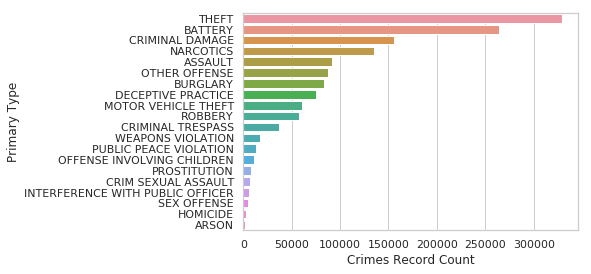

In [15]:
## Just some seaborn params for a better view
sns.set(style="whitegrid")
sns.set_color_codes("dark")

type_graph = sns.barplot(x='count', y='primary_type', data=counts_pddf)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

#Visualizing data records by primary type and their count

[Text(0,0.5,'location description'), Text(0.5,0,'Crimes Record Count')]

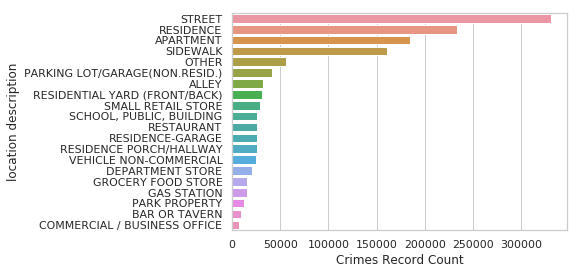

In [16]:
type_graph = sns.barplot(x='count', y='location_description', data=counts_pddf_loc)
type_graph.set(ylabel="location description", xlabel="Crimes Record Count")

#Visualizing data records by primary type and their count

### Recorded Date

In [17]:
df.select(min('date').alias('first_rec'), max('date').alias('last_rec')).show(truncate=False)
df.select((datediff(to_date(max('date'), "MM/dd/yyyy"), to_date(min('date'), "MM/dd/yyyy"))/365).alias('duration')).show()

+----------------------+----------------------+
|first_rec             |last_rec              |
+----------------------+----------------------+
|01/01/2012 01:00:00 AM|12/31/2016 12:56:00 AM|
+----------------------+----------------------+

+-----------------+
|         duration|
+-----------------+
|5.002739726027397|
+-----------------+



---
#### Prepare dates for stats viewing :

###### We will prepare dates columns in order to facilitate data viswualisation based on dates:
###### Convert dates from string to Timestamp + add columns


In [18]:
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', trunc('date_time', 'MM'))\
       .withColumn('year', trunc('date_time', 'yyyy'))

### Statistics based on dates

In [19]:
# crime types and arrest over years:
type_arrest_date = df.groupBy(['arrest', 'month']).count().orderBy(['count'], ascending=[True, False])
type_arrest_date = type_arrest_date.dropna()
type_arrest_date.show(4, truncate=False)

+------+----------+-----+
|arrest|month     |count|
+------+----------+-----+
|true  |2017-01-01|1902 |
|true  |2016-12-01|3088 |
|true  |2016-11-01|3385 |
|true  |2016-10-01|3783 |
+------+----------+-----+
only showing top 4 rows



In [20]:
# locations of crimes and arrest over years:
loc_arrest_date = df.groupBy(['arrest','location_description', 'month']).count().orderBy(['count'], ascending=[True, False])
loc_arrest_date = loc_arrest_date.dropna()
loc_arrest_date.show(3, truncate=False)

+------+-------------------------+----------+-----+
|arrest|location_description     |month     |count|
+------+-------------------------+----------+-----+
|false |FOREST PRESERVE          |2013-05-01|1    |
|true  |CTA TRACKS - RIGHT OF WAY|2014-04-01|1    |
|true  |DAY CARE CENTER          |2013-07-01|1    |
+------+-------------------------+----------+-----+
only showing top 3 rows



In [21]:
## Construct a pandas DF from the collected dictionary of the RDD
temp_type_arrest_date = type_arrest_date
type_arrest_pddf = pd.DataFrame(type_arrest_date.rdd.map(lambda l: l.asDict()).collect())

## Add a column for Year & column for Month's name
## We also should drop NaN values 

type_arrest_pddf = type_arrest_pddf.dropna()
type_arrest_pddf['yearcr'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%Y'))
#type_arrest_pddf['monthcr'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%m'))
type_arrest_pddf['monthName'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%b'))

In [22]:
type_arrest_pddf.head(5)

,arrest,count,month,yearcr,monthName
0,True,1902,2017-01-01,2017,Jan
1,True,3088,2016-12-01,2016,Dec
2,True,3385,2016-11-01,2016,Nov
3,True,3783,2016-10-01,2016,Oct
4,True,3831,2016-09-01,2016,Sep


In [23]:
# Data for plotting

arrest_by_year = type_arrest_pddf[['yearcr', 'count', 'arrest']].copy()

## Let's filter all False Arrests => we have all True arrests
indexNames = arrest_by_year[ arrest_by_year['arrest'] == False ].index

# Delete these row indexes from dataFrame
arrest_by_year.drop(indexNames , inplace=True)

## Same for False arrests
notarrest_by_year = type_arrest_pddf[['yearcr', 'count', 'arrest']].copy()

## Let's filter all True Arrests => we have all False arrests
indexNames = notarrest_by_year[ notarrest_by_year['arrest'] == True ].index

# Delete these row indexes from dataFrame
notarrest_by_year.drop(indexNames , inplace=True)

arrest_by_year.head(5)

,yearcr,count,arrest
0,2017,1902,True
1,2016,3088,True
2,2016,3385,True
3,2016,3783,True
4,2016,3831,True


In [24]:
notarrest_by_year.head(5)

,yearcr,count,arrest
61,2017,9455,False
62,2015,11162,False
63,2014,12178,False
64,2014,14170,False
65,2016,14442,False


In [25]:
arrest_by_year = arrest_by_year.groupby(['yearcr']).sum()
notarrest_by_year = notarrest_by_year.groupby(['yearcr']).sum()

### Now we have Crimes over all the years and also their status = Arrest / No arrest

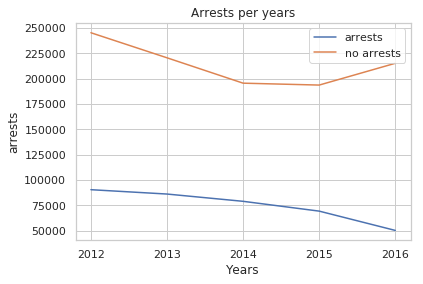

In [26]:
## Let's view those arrests by years 

fig, ax = plt.subplots()
months = ['2012','2013','2014','2015', '2016']
ax.plot(months, arrest_by_year['count'].drop('2017'), label='arrests')
ax.plot(months, notarrest_by_year['count'].drop('2017'), label='no arrests')

ax.set(xlabel='Years', ylabel='arrests',title='Arrests per years')
ax.grid(b=True, which='both', axis='y')
ax.legend()

### Distance between Arrests & Non-arrests increased between 2015 & 2016

#### Add column for hourly based analysis

In [27]:
df_hour = df.withColumn('hour', hour(df['date_time']))

## Clean data
df_hour = df_hour.dropna()

## Count crimes by hours & types
hourly_count = df_hour.groupBy(['primary_type', 'hour']).count().cache()
hourly_count.show(5)

+-----------------+----+-----+
|     primary_type|hour|count|
+-----------------+----+-----+
|WEAPONS VIOLATION|  23| 1228|
|        OBSCENITY|  14|    7|
|        OBSCENITY|  11|    7|
|          ROBBERY|  14| 2340|
|      SEX OFFENSE|  18|  220|
+-----------------+----+-----+
only showing top 5 rows



In [28]:
## Regroup crimes by hours and sum number of crimes we counted

hourly_total_count = hourly_count.groupBy('hour').sum('count')
hourly_total_count.show()

+----+----------+
|hour|sum(count)|
+----+----------+
|  12|     80695|
|  22|     74581|
|   1|     42954|
|  13|     67802|
|   6|     23834|
|  16|     74338|
|   3|     30447|
|  20|     79262|
|   5|     19758|
|  19|     82454|
|  15|     78011|
|   9|     64571|
|  17|     73841|
|   4|     22840|
|   8|     48842|
|  23|     60217|
|   7|     33667|
|  10|     62989|
|  21|     75164|
|  11|     65280|
+----+----------+
only showing top 20 rows



In [29]:
## Create a pandas dataframe from hourly_data_count
collected_dict = hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'])\
                                .rdd.map(lambda l: l.asDict())\
                                .collect()

hourly_count_pddf = pd.DataFrame(collected_dict).sort_values(by='hour')

hourly_count_pddf.head(5)

,hour,sum(count)
22,0,67602
2,1,42954
21,2,36774
6,3,30447
13,4,22840


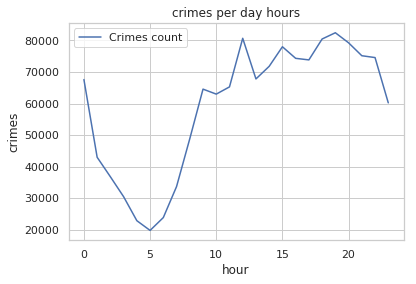

In [30]:
fig, ax = plt.subplots()
ax.plot(hourly_count_pddf['hour'], hourly_count_pddf['sum(count)'], label='Crimes count')

ax.set(xlabel='hour', ylabel='crimes', title='crimes per day hours')
ax.grid(b=True, which='y', axis='y')
ax.legend()